<a href="https://colab.research.google.com/github/dwihdyn/algo-trading/blob/master/backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Reference : https://www.oreilly.com/library/view/hands-on-algorithmic-trading/9781492082637/** 

Module 4.3 : Backtesting Algorithm

Summary :
1.   Pull & cleanse data
2.   Calculate Simple Moving Average (SMA) from the stock data
3.   Created two strategies (long only & sma crossover) and compare them
4.   Backtest & plot result in profit/loss chart
5.   See the profit/loss % made by the end of the trading day & summary of the strategy

# IMPORT MODULES

In [0]:
import pandas as pd
import numpy as np
import pandas_datareader.data as pdr
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import requests
import json

# PROCESS TRADING DATA

In [21]:
# pull data | # RKKWDNO3XD91IUBZ -> EXXJQAB3KQ91VHOM (http://decode.org/)
response = requests.get('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=MSFT&apikey=demo')
alphadict = json.loads(response.text)
stock = pd.DataFrame(alphadict['Time Series (Daily)']).T

# clean data
stock.index = pd.to_datetime(stock.index) # convert tableIndex from string to datetime
stock.columns = ['open', 'high', 'low', 'close' , 'volume'] # rename the columns
stock = stock.astype(float)  # convert all price value from string to float
stock = stock.sort_index(ascending=True) # sort table by its index
stock.head()

,open,high,low,close,volume
2019-08-16,134.880,136.4600,134.720,136.13,25026151.0
2019-08-19,137.855,138.5500,136.885,138.41,24370543.0
2019-08-20,138.210,138.7100,137.240,137.26,21188998.0
2019-08-21,138.550,139.4935,138.000,138.79,14982314.0
2019-08-22,138.660,139.2000,136.290,137.78,18709662.0


# GENERATE TRADING SIGNAL

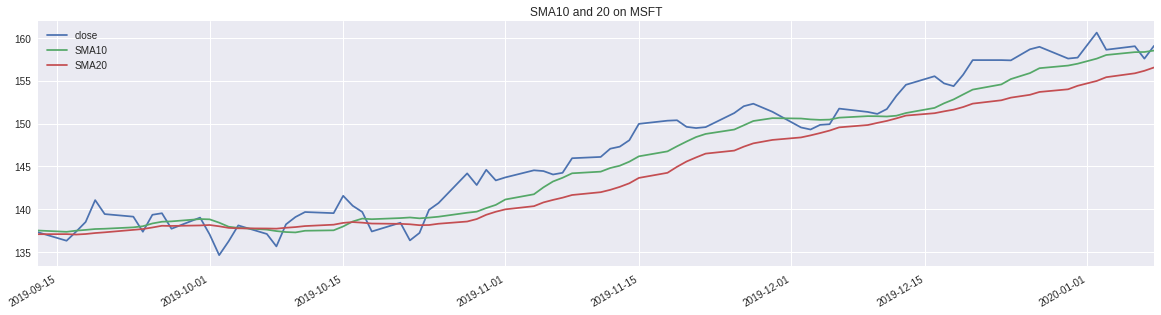

In [22]:
# self-calculate SMA
stock['SMA10'] = stock['close'].rolling(10).mean()
stock['SMA20'] = stock['close'].rolling(20).mean()
stock.dropna(inplace=True)

# plot in chart
stock[['close', 'SMA10', 'SMA20']].plot(figsize=(20,5), grid=True, title='SMA10 and 20 on MSFT'), plt.show();

# VECTORIZED BACKTESTING

In [23]:
# created two strategies (long_only & smal_strategy) & combine them to the main table

stock['position'] = np.where(stock['SMA10'] > stock['SMA20'],1,-1) # buy 1 lot if (sma10 > sma20), sell 1 lot if (sma10 < sma20)
stock['long_only'] = np.log(stock['close']/stock['close'].shift(1))  # closing price difference . this standalone can be used if strategy is just to buy only (was named 'returns')
stock['sma_strategy'] = stock['position'].shift(1) * stock['long_only'] # price difference * position from strategy = profit made from startegy (was named 'strategy')
stock.dropna(inplace=True)
stock.head()

,open,high,low,close,volume,SMA10,SMA20,position,long_only,sma_strategy
2019-09-16,135.83,136.70,135.6600,136.33,16731440.0,137.371,137.1035,1,-0.007236,-0.007236
2019-09-17,136.96,137.52,136.4250,137.39,17976285.0,137.506,137.0525,1,0.007745,0.007745
2019-09-18,137.36,138.67,136.5299,138.52,24473386.0,137.595,137.1155,1,0.008191,0.008191
2019-09-19,140.30,142.37,140.0736,141.07,36095413.0,137.697,137.2295,1,0.018242,0.018242
2019-09-20,141.01,141.65,138.2500,139.44,40040766.0,137.731,137.3125,1,-0.011622,-0.011622


# EVALUATE PERFORMANCE - BACKTEST

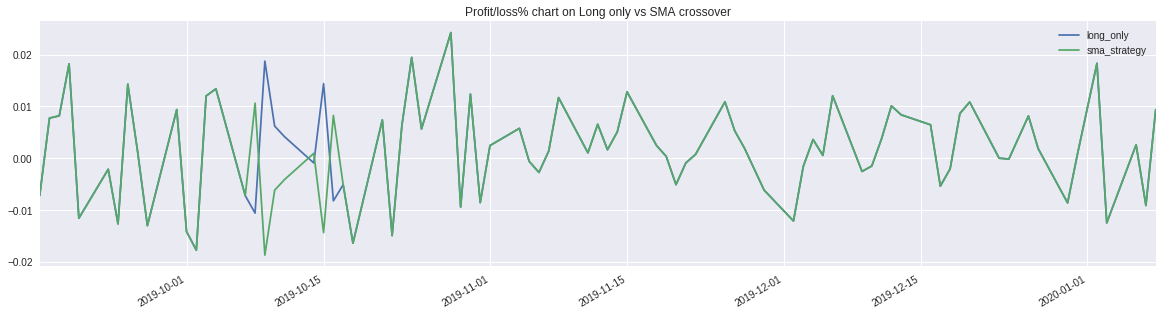

(<matplotlib.axes._subplots.AxesSubplot at 0x7f5cde642c50>, None)

In [24]:
# plot profit/loss% chart. 0 means no profit made. good strategy is when this chart is keep increasing

# some of the plot MAY BE converge to a line is because (sma10 > sma20) throughout the whole period, hence its long only
stock[['long_only', 'sma_strategy']].plot(figsize=(20,5), grid=True, title='Profit/loss% chart on Long only vs SMA crossover'), plt.show()

## Profit/loss% made from the strategies, by the end of the trading day

In [25]:
# see the total profit/loss (in percentage) made from this strategy
# if the output is 1.10, means we have made 10% of profit

np.exp(stock[['long_only', 'sma_strategy']].sum()) # need to exponential to cancel out the log

long_only       1.158350
sma_strategy    1.104702
dtype: float64

In [26]:
# statistic summary of the strategies

np.exp(stock['long_only'])
stock[['long_only', 'sma_strategy']].describe()

,long_only,sma_strategy
count,80.000000,80.000000
mean,0.001837,0.001245
std,0.009328,0.009427
min,-0.017813,-0.018766
25%,-0.005135,-0.005210
50%,0.001728,0.001339
75%,0.008239,0.008209
max,0.024289,0.024289
